<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">卷积神经网络实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2024年1月14日</span></div>
</div>

实验环境：
- OS：Ubuntu 22.04.3 LTS (GNU/Linux 6.5.0-14-generic x86_64)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.3
- conda: miniconda 23.11.0
- python：3.10.13
- torch：2.1.1

In [1]:
import torch
from torch import nn
import numpy as np

from dataset import *
from utils import *

# 4-超参数对比

- 不同超参数的对比分析（包括hidden_size、batch_size、lr等）选其中至少1-2个进行分析。

这里使用LSTM模型进行训练和测试。


### 4.1. 比较hidden_size超参数

hidden size = 32: 
Final result: Get best validation rmse 3.5272 at epoch 79, Total time 2.26s
Test result: Test RMSE: 11.199715814298292, Test MAE: 7.2207662264506025, Test MAPE: 27.1881602704525
hidden size = 64: 
Final result: Get best validation rmse 3.4089 at epoch 79, Total time 2.16s
Test result: Test RMSE: 9.405383118496854, Test MAE: 6.057014107704163, Test MAPE: 23.08445746699969
hidden size = 128: 
Final result: Get best validation rmse 3.3710 at epoch 77, Total time 3.12s
Test result: Test RMSE: 8.720216366178343, Test MAE: 5.637649297714233, Test MAPE: 21.778428306182224
hidden size = 256: 
Final result: Get best validation rmse 3.1181 at epoch 79, Total time 3.96s
Test result: Test RMSE: 8.07831416273141, Test MAE: 5.118967294692993, Test MAPE: 19.402874012788136


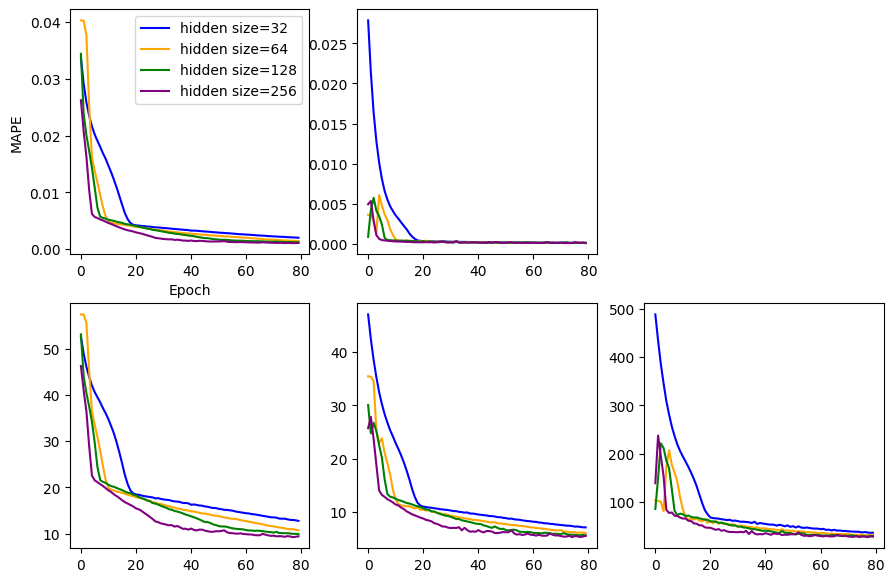

In [2]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :].squeeze(-1)
        x = self.fc(x).squeeze(-1)
        return x


if __name__ == "__main__":
    plt.figure(figsize=(10.5, 7))
    hidden_sizes = [
        [32, 'blue'],
        [64, 'orange'],
        [128, 'green'],
        [256, 'purple']
    ]
    for parameters in hidden_sizes:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        batch_size = 256
        learning_rate = 1e-4
        num_epoch = 80
        
        KrakowData = KrakowDataset()
        train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)
        train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
        val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
        test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
        input_size = train_set.seqs.shape[-1]
        seq_len = 12
        hidden_size = parameters[0]
        output_size = 1
    
        criterion = nn.MSELoss()
        model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

        print(f'hidden size = {hidden_size}: ')
        train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
            net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
            denormalize_fn=KrakowData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
            device=device, num_print_epoch_round=0
        )
        x = np.arange(0, stop_epoch + 1).astype(dtype=np.int32)
        plt.subplot(2, 3, 1)
        plt.plot(x, train_loss_lst, label=f"hidden size={hidden_size}", linewidth=1.5, c=parameters[1])
        plt.subplot(2, 3, 2)
        plt.plot(x, val_loss_lst, label=f"hidden size={hidden_size}", linewidth=1.5, c=parameters[1])
        train_score_lst = np.array(train_score_lst)
        plt.subplot(2, 3, 4)
        plt.plot(x, train_score_lst[:, 0], label=f"hidden size={hidden_size}", linewidth=1.5, c=parameters[1])
        plt.subplot(2, 3, 5)
        plt.plot(x, train_score_lst[:, 1], label=f"hidden size={hidden_size}", linewidth=1.5, c=parameters[1])
        plt.subplot(2, 3, 6)
        plt.plot(x, train_score_lst[:, 2], label=f"hidden size={hidden_size}", linewidth=1.5, c=parameters[1])
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()

可以看出，hidden size越大，模型的性能越强，收敛速度越快，但是训练速度越慢。

### 4.2. 比较batch_size超参数

batch size = 64: 
The model has not been improved for 20 rounds. Stop early!
Final result: Get best validation rmse 2.6760 at epoch 51, Total time 8.07s
Test result: Test RMSE: 7.048437028059537, Test MAE: 4.796792855629554, Test MAPE: 17.947290207330997
batch size = 128: 
Final result: Get best validation rmse 2.8693 at epoch 79, Total time 5.20s
Test result: Test RMSE: 7.3397364631615805, Test MAE: 4.728430913044856, Test MAPE: 17.329148948192596
batch size = 256: 
Final result: Get best validation rmse 3.2049 at epoch 74, Total time 3.93s
Test result: Test RMSE: 8.74032459218199, Test MAE: 5.831349770228068, Test MAPE: 23.814469824234646
batch size = 512: 
Final result: Get best validation rmse 3.6801 at epoch 75, Total time 2.81s
Test result: Test RMSE: 9.97526490022097, Test MAE: 6.630318959554036, Test MAPE: 24.888519446055096


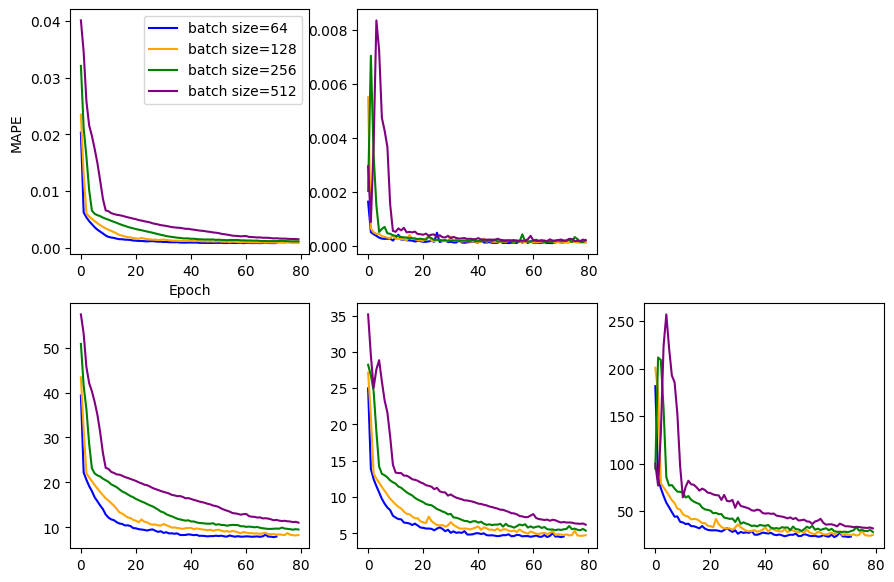

In [3]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size), 
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :].squeeze(-1)
        x = self.fc(x).squeeze(-1)
        return x


if __name__ == "__main__":
    plt.figure(figsize=(10.5, 7))
    batch_sizes = [
        [64, 'blue'],
        [128, 'orange'],
        [256, 'green'],
        [512, 'purple']
    ]
    for parameters in batch_sizes:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        batch_size = parameters[0]
        learning_rate = 1e-4
        num_epoch = 80
        
        KrakowData = KrakowDataset()
        train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)
        train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=14, drop_last=True)
        val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
        test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=14, drop_last=True)
        input_size = train_set.seqs.shape[-1]
        seq_len = 12
        hidden_size = 256
        output_size = 1
    
        criterion = nn.MSELoss()
        model = Model(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

        print(f'batch size = {batch_size}: ')
        train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, stop_epoch = train(
            net=model, train_iter=train_loader, val_iter=val_loader, test_iter=test_loader, loss_fn=criterion, 
            denormalize_fn=KrakowData.denormalize, optimizer=optimizer, num_epoch=num_epoch, early_stop=20, 
            device=device, num_print_epoch_round=0
        )
        x = np.arange(0, stop_epoch + 1).astype(dtype=np.int32)
        plt.subplot(2, 3, 1)
        plt.plot(x, train_loss_lst, label=f"batch size={batch_size}", linewidth=1.5, c=parameters[1])
        plt.subplot(2, 3, 2)
        plt.plot(x, val_loss_lst, label=f"batch size={batch_size}", linewidth=1.5, c=parameters[1])
        train_score_lst = np.array(train_score_lst)
        plt.subplot(2, 3, 4)
        plt.plot(x, train_score_lst[:, 0], label=f"batch size={batch_size}", linewidth=1.5, c=parameters[1])
        plt.subplot(2, 3, 5)
        plt.plot(x, train_score_lst[:, 1], label=f"batch size={batch_size}", linewidth=1.5, c=parameters[1])
        plt.subplot(2, 3, 6)
        plt.plot(x, train_score_lst[:, 2], label=f"batch size={batch_size}", linewidth=1.5, c=parameters[1])
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.subplot(2, 3, 1)
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()

从曲线可以看出，batch size越大，收敛越平稳，单个epoch训练越快。但是由于learning rate恒定，每个batch越大，数据分布的方差越大，因此loss下降越慢。